In [1]:
import gsw
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
from scipy.io import loadmat
import os
import pandas as pd

In [3]:
def bin_average(var, var_lev, lev_bounds, nmin=5):
    n_av = len(lev_bounds)-1
    var_av = np.zeros(n_av)
    for k in range(n_av):
        idx = (var_lev >= lev_bounds[k]) & (var_lev < lev_bounds[k+1])
        if sum(~np.isnan(var[idx])) > nmin:
            var_av[k] = np.nanmean(var[idx])
        else:
            var_av[k] = np.nan
    return var_av

In [4]:
jims_notes = pd.read_csv(
    "../../data/HRP_97_Dive_List.txt", delim_whitespace=True, header=0,
    names=["HRP no.", "lon", "lat", "Min. HAB", "CTD no."],
    usecols=[0, 1, 2, 3, 4],
    dtype={"HRP no.": np.int64}
)

## PRE-PROCESS Jim Ledwell's CTD DATA

In [5]:
casts = [filename for filename in os.listdir("../../data/DataForXiaozhou/ctd/full/") if ".mat" in filename]

df = pd.DataFrame()
for cast in casts:
    data = loadmat(f"../../data/DataForXiaozhou/ctd/full/{cast}")

    salinity = np.nanmean(np.concatenate((data['s1'], data['s2']), axis=1), axis=1)
    temperature = np.nanmean(np.concatenate((data['t1'], data['t2']), axis=1), axis=1)
    
    # Basic quality control for obvious (abyssal ocean) outliers
    mask = (np.abs(salinity - 34.9) > 0.5) | (np.abs(temperature - 2.) > 4.)
    salinity[mask] = np.nan
    temperature[mask] = np.nan
    
    pressure = data['pr'].squeeze()
    sigma4 = gsw.sigma4(salinity, gsw.CT_from_t(salinity, temperature, pressure))
    
    bottom_pressure = max(data['BottomP'], data['Maxp'], np.max(pressure)).squeeze()
    if np.isnan(bottom_pressure): continue
        
    cast_HRP = jims_notes[jims_notes['CTD no.']==data['castnum'].squeeze()]['HRP no.'].values[0]
    
    tmp = pd.DataFrame({
        'cast number (CTD)': data['castnum'].squeeze(),
        'cast number (HRP)': cast_HRP,
        'bottom pressure': bottom_pressure,
        'latitude': -data['Lat'].squeeze(),
        'longitude': -data['Lon'].squeeze(),
        'pressure': pressure,
        'depth': gsw.z_from_p(pressure, -data['Lat'].squeeze()),
        'bottom depth': gsw.z_from_p(bottom_pressure, -data['Lat'].squeeze()),
        'salinity': salinity,
        'temperature': temperature,
        'sigma4': sigma4,
    })
    
    df = df.append(tmp)

In [73]:
g = 9.81
ρ0 = 1035.

dp = 50.
pmin = 2000.
pmax = 6500.
new_pressure_f = np.arange(pmin-dp/2., pmax+dp/2, dp)
new_pressure = np.arange(pmin, pmax, dp)

cdf = pd.DataFrame()
for castnum in np.sort(df['cast number (CTD)'].unique()):
    cast_df = df[df['cast number (CTD)'] == castnum]
    tmp = pd.DataFrame({
        'cast number (CTD)': castnum,
        'cast number (HRP)': cast_df['cast number (HRP)'][0],
        'bottom pressure': bin_average(cast_df['bottom pressure'], cast_df['pressure'], new_pressure_f),
        'latitude': bin_average(cast_df['latitude'], cast_df['pressure'], new_pressure_f),
        'longitude': bin_average(cast_df['longitude'], cast_df['pressure'], new_pressure_f),
        'pressure': new_pressure,
        'depth': bin_average(cast_df['depth'], cast_df['pressure'], new_pressure_f),
        'bottom depth': bin_average(cast_df['bottom depth'], cast_df['pressure'], new_pressure_f),
        'salinity': bin_average(cast_df['salinity'], cast_df['pressure'], new_pressure_f),
        'temperature': bin_average(cast_df['temperature'], cast_df['pressure'], new_pressure_f),
        'sigma4': bin_average(cast_df['sigma4'], cast_df['pressure'], new_pressure_f),
    })
    
    tmp['depth_f'] = 0.5*(tmp['depth'][0:-1] + tmp['depth'][1:])
    tmp['pressure_f'] = 0.5*(tmp['pressure'][0:-1] + tmp['pressure'][1:])
    tmp['Nsq'] = np.concatenate([g/ρ0 * np.diff(tmp['sigma4']) / np.diff(tmp['pressure']), np.array([np.nan])])
    
    cdf = cdf.append(tmp)
    
dhab = 50.
habmin = 0.
habmax = 3000.
hab_f = np.arange(habmin-dhab/2., habmax+dhab/2, dhab)
hab = np.arange(habmin, habmax, dhab)

hdf = pd.DataFrame()
for castnum in np.sort(df['cast number (CTD)'].unique()):
    cast_df = df[df['cast number (CTD)'] == castnum]
    height_above_bottom = cast_df['depth'] - cast_df['bottom depth']
    tmp = pd.DataFrame({
        'cast number (CTD)': castnum,
        'cast number (HRP)': cast_df['cast number (HRP)'][0],
        'bottom pressure': bin_average(cast_df['bottom pressure'], height_above_bottom, hab_f),
        'latitude': bin_average(cast_df['latitude'], height_above_bottom, hab_f),
        'longitude': bin_average(cast_df['longitude'], height_above_bottom, hab_f),
        'height above bottom': hab,
        'salinity': bin_average(cast_df['salinity'], height_above_bottom, hab_f),
        'temperature': bin_average(cast_df['temperature'], height_above_bottom, hab_f),
        'sigma4': bin_average(cast_df['sigma4'], height_above_bottom, hab_f),
    })
    
    tmp['height_f above bottom'] = 0.5*(tmp['height above bottom'][:-1] + tmp['height above bottom'][1:])
    tmp['Nsq'] = np.concatenate([-g/ρ0 * np.diff(tmp['sigma4']) / np.diff(tmp['height above bottom']), np.array([np.nan])])
    
    hdf = hdf.append(tmp)

### Plotting in depth coordinates

(0.0, 3e-06)

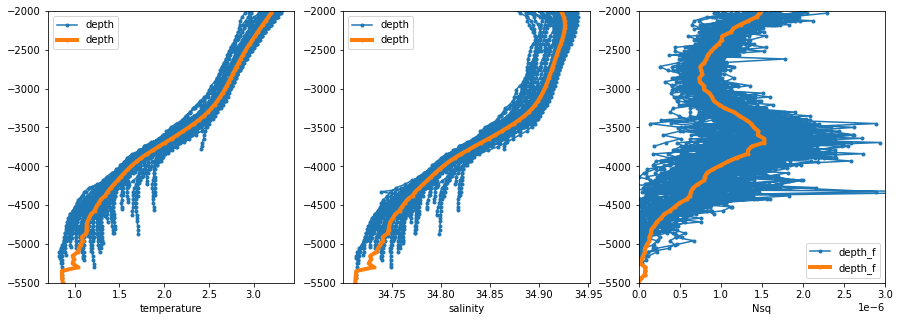

In [74]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
cdf.plot(x='temperature', y='depth',marker='.', ax=axes[0])
cdf.groupby('pressure').mean().reset_index().plot(x='temperature', y='depth',marker='.', color='C1', lw=4, ax=axes[0])

cdf.plot(x='salinity', y='depth',marker='.', ax=axes[1])
cdf.groupby('pressure').mean().reset_index().plot(x='salinity', y='depth',marker='.', color='C1', lw=4, ax=axes[1])

cdf.plot(x='Nsq', y='depth_f',marker='.', ax=axes[2])
cdf.groupby('pressure_f').mean().reset_index().plot(x='Nsq', y='depth_f',marker='.', color='C1', lw=4, ax=axes[2])

for ax in axes:
    ax.set_ylim([-5500,-2000])
axes[2].set_xlim([0., 3.e-6])

### Heigth-above-bottom coordinates

(0.0, 3e-06)

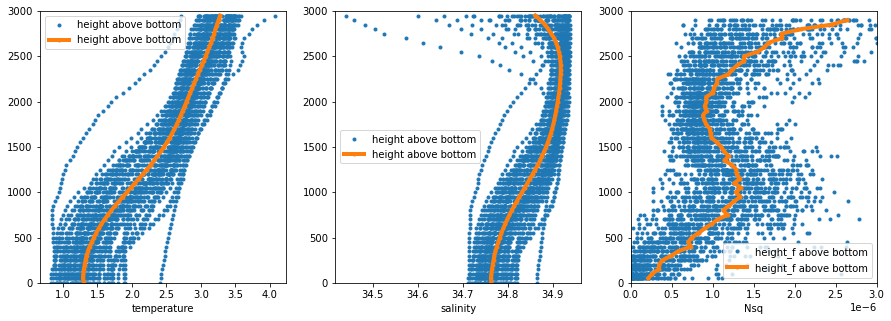

In [75]:
fig, axes = plt.subplots(1,3, figsize=(15,5))
hdf.plot(x='temperature', y='height above bottom', lw=0., marker='.', ax=axes[0])
hdf.groupby('height above bottom').mean().reset_index().plot(x='temperature', y='height above bottom',marker='.', color='C1', lw=4, ax=axes[0])

hdf.plot(x='salinity', y='height above bottom', lw=0., marker='.', ax=axes[1])
hdf.groupby('height above bottom').mean().reset_index().plot(x='salinity', y='height above bottom',marker='.', color='C1', lw=4, ax=axes[1])


hdf.plot(x='Nsq', y='height_f above bottom', lw=0., marker='.', ax=axes[2])
hdf.groupby('height_f above bottom').mean().reset_index().plot(x='Nsq', y='height_f above bottom',marker='.', color='C1', lw=4, ax=axes[2])

for ax in axes:
    ax.set_ylim([0, 3000])
axes[2].set_xlim([0., 3.e-6])

In [76]:
df.to_csv("../../data/BBTRE_hydrography_full.csv")
cdf.to_csv("../../data/BBTRE_hydrography_z-binned.csv")
hdf.to_csv("../../data/BBTRE_hydrography_hab-binned.csv")

## Pre-process the BBTRE-1997 microstructure data

In [77]:
def assign_coords(ds):
    for name in ['LATITUDE', 'LONGITUDE', 'TIME', 'BOT_DEPTH']:
        coord = xr.DataArray(
            np.array([ds[name].values]), (ds['CAST'],),
        )
    return ds.assign_coords({name: coord})

def preprocess(ds):
    ds = ds.drop(['CHI-T']).squeeze()
    _, index = np.unique(ds.DEPTH, return_index=True)
    ds = ds.isel(DEPTH=index)
    index = ~np.isnan(ds.DEPTH)
    ds = ds.isel(DEPTH=index)

    c = np.int64(ds.attrs['cast_number'])
    ds = ds.expand_dims({'CAST': [c]})
    ds = assign_coords(ds)
    
    # Apply fill value to mask bad values
    ds['BOT_DEPTH'] = ds['BOT_DEPTH'].where(ds['BOT_DEPTH']!=-99.)
    ds["BOT_DEPTH_UCSD"] = ds['BOT_DEPTH'].copy()
    
    jims_note = jims_notes[jims_notes["HRP no."] == c]
    if ~np.isnan(jims_note["Min. HAB"].values[0]):
        ds['max_depth'] = (ds["DEPTH"].where(~np.isnan(ds["EPSILON"]))).max("DEPTH")
        ds['BOT_DEPTH'] = ds['max_depth'] + jims_note["Min. HAB"]
    
    ## SHOULD BE BINNED AVERAGES, NOT INTERPOLATION. I THINK THIS SHOULD BE EASY WITH XHISTOGRAM
    DEPTH = xr.DataArray(np.arange(2000.,6500., 1.), coords={'DEPTH': np.arange(2000.,6500., 1.)}, dims=['DEPTH'])
    ds = ds.interp(DEPTH=DEPTH)
    return ds

In [78]:
import matplotlib

Year 96 has 45 valid bottom depths out of 48
Year 97 has 79 valid bottom depths out of 79


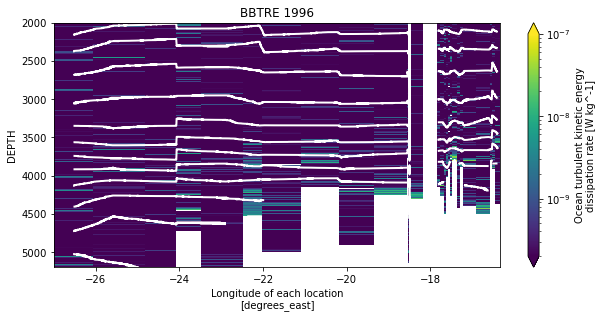

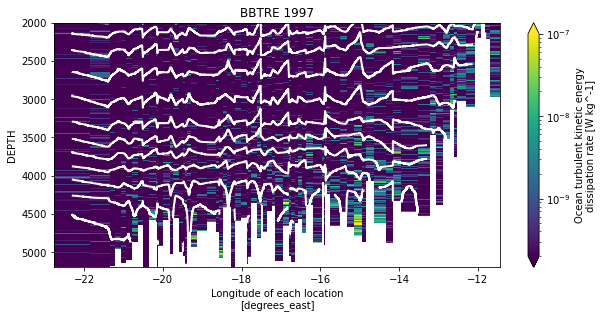

In [79]:
for year in ["96", "97"]:
    microstructure = xr.open_mfdataset(f"../../data/bbtre{year}_microstructure/bbtre*.nc", preprocess=preprocess, combine='by_coords')
    microstructure = microstructure.isel(CAST = (microstructure["LONGITUDE"] >= -27))
    N = np.sum(~np.isnan(microstructure["BOT_DEPTH"])).values
    Nt = microstructure["BOT_DEPTH"].size
    print(f"Year {year} has {N} valid bottom depths out of {Nt}")
    
    plt.figure(figsize=(10,4.5))
    σ4 = gsw.sigma4(microstructure['PSAL'], gsw.CT_from_t(microstructure['PSAL'], microstructure['TEMPERATURE'], microstructure['PRESSURE']))
    microstructure['σ4'] = xr.DataArray(σ4, (microstructure['CAST'], microstructure['DEPTH'],))

    microstructure['EPSILON'].sortby('LONGITUDE').plot(y='DEPTH', x='LONGITUDE', norm=matplotlib.colors.LogNorm(vmin=2.e-10, vmax=1.e-7))
    microstructure['σ4'].sortby('LONGITUDE').plot.contour(y='DEPTH', x='LONGITUDE', colors='w', levels=np.arange(45.5, 46.0, 0.03), linewidths=2.)
    plt.ylim([5200,2000])
    plt.title(f"BBTRE 19{year}")

    microstructure.to_netcdf(f"../../data/BBTRE{year}_microstructure_full.nc")

Text(0, 0.5, "Corrected Bottom Depths (from Jim's notes)")

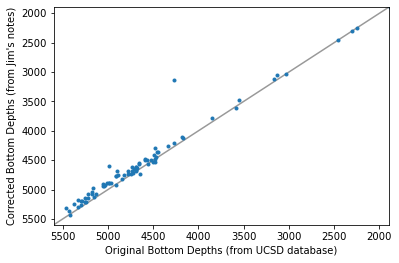

In [80]:
plt.plot([0, 10000], [0, 10000], "k-", alpha=0.4)
plt.plot(microstructure['BOT_DEPTH_UCSD'], microstructure['BOT_DEPTH'], ".", label="UCSD Microstructure")
plt.ylim(5600, 1900)
plt.xlim(5600, 1900)
plt.xlabel("Original Bottom Depths (from UCSD database)")
plt.ylabel("Corrected Bottom Depths (from Jim's notes)")